In [1]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= -3.5]
opv_df_filtered.reset_index(drop=True, inplace=True)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    
    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)
        
        for sim_metric in similarities:
            opv_df_sim_segment = opv_df_filtered.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))
            
            # Filter top 48% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.50)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]
            
            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'GAP_calc', f'similarity_{key}_{fp_type}_{sim_metric}']]
            
            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (6365, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (6481, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (6394, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (6365, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (6363, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (6361, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (6384, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (6363, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity tanimoto: shape (6361, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity cosine: shape (6452, 4)
Generated dataframe for segment seg02,

In [8]:
opv_df_filtered.columns

Index(['smiles', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'HOMO_calib',
       'GAP_calib', 'GAP_calc', 'mol'],
      dtype='object')

In [9]:
similarity_dfs["seg01_atom_pair_cosine"].columns

Index(['smiles', 'mol', 'GAP_calc', 'similarity_seg01_atom_pair_cosine'], dtype='object')

In [2]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    df = df.copy()
    
    # Generate Morgan fingerprints
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert Morgan fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing seg01_morgan_tanimoto...
Finished processing seg01_morgan_tanimoto - shape (6365, 2052)
Processing seg01_morgan_cosine...
Finished processing seg01_morgan_cosine - shape (6481, 2052)
Processing seg01_morgan_kulczynski...
Finished processing seg01_morgan_kulczynski - shape (6394, 2052)
Processing seg01_morgan_dice...
Finished processing seg01_morgan_dice - shape (6365, 2052)
Processing seg01_atom_pair_tanimoto...
Finished processing seg01_atom_pair_tanimoto - shape (6363, 2052)
Processing seg01_atom_pair_cosine...
Finished processing seg01_atom_pair_cosine - shape (6361, 2052)
Processing seg01_atom_pair_kulczynski...
Finished processing seg01_atom_pair_kulczynski - shape (6384, 2052)
Processing seg01_atom_pair_dice...
Finished processing seg01_atom_pair_dice - shape (6363, 2052)
Processing seg02_morgan_tanimoto...
Finished processing seg02_morgan_tanimoto - shape (6361, 2052)
Processing seg02_morgan_cosine...
Finished processing seg02_morgan_cosine - shape (6452, 2052)
Proces

In [3]:
processed_similarity_dfs["seg01_atom_pair_cosine"].columns

Index(['smiles', 'mol', 'GAP_calc', 'similarity_seg01_atom_pair_cosine',
       'morgan_0', 'morgan_1', 'morgan_2', 'morgan_3', 'morgan_4', 'morgan_5',
       ...
       'morgan_2038', 'morgan_2039', 'morgan_2040', 'morgan_2041',
       'morgan_2042', 'morgan_2043', 'morgan_2044', 'morgan_2045',
       'morgan_2046', 'morgan_2047'],
      dtype='object', length=2052)

In [5]:
processed_similarity_dfs["seg01_atom_pair_cosine"].head()

,smiles,mol,GAP_calc,similarity_seg01_atom_pair_cosine,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,O=C(O)c1noc(-c2c3c(c(-c4onc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x000001B80E0...,1.741529,0.591960,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1onc(-c2c3c(c(-c4noc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x000001B80F9...,1.770480,0.618590,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cn1c(C2=CC(=C(C#N)C#N)C=C(C(=O)C3=CC(=C(C#N)C#...,<rdkit.Chem.rdchem.Mol object at 0x000001B80E0...,2.414079,0.621637,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,O=C(O)c1csc(-c2c3c(c(-c4scc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x000001B80FE...,1.754234,0.659829,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CC1(C)OC(=C(C#N)C#N)C(C#N)=C1C1=CC(=C(C#N)C#N)...,<rdkit.Chem.rdchem.Mol object at 0x000001B80FA...,1.747445,0.594765,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
import pandas as pd
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.model_selection import train_test_split

df = processed_similarity_dfs["seg01_atom_pair_cosine"]
X = df.iloc[:, 4:]
y = df['GAP_calc']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
model = lgb.LGBMRegressor(**tuned_params)

n_features_to_select = 50 
rfe = RFE(model, n_features_to_select=n_features_to_select)

# Fit RFE
rfe.fit(X_train, y_train)

# Get the rankings of features
ranking = rfe.ranking_

# Get the selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:")
print(selected_features)

model.fit(X_train[selected_features], y_train)
print("Training score:", model.score(X_train[selected_features], y_train))
print("Test score:", model.score(X_test[selected_features], y_test))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 860
[LightGBM] [Info] Start training from score 2.662920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 860
[LightGBM] [Info] Start training from score 2.662920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 50
[LightGBM] [Info] Start training from score 2.662920
Test Score (R²): 0.8681
Test MAE: 0.1339
Test RMSE: 0.1897
Curcumin Prediction MAE: 0.2036
Curcumin Prediction RMSE: 0.2289
Average Absolute Variance: 0.2036


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


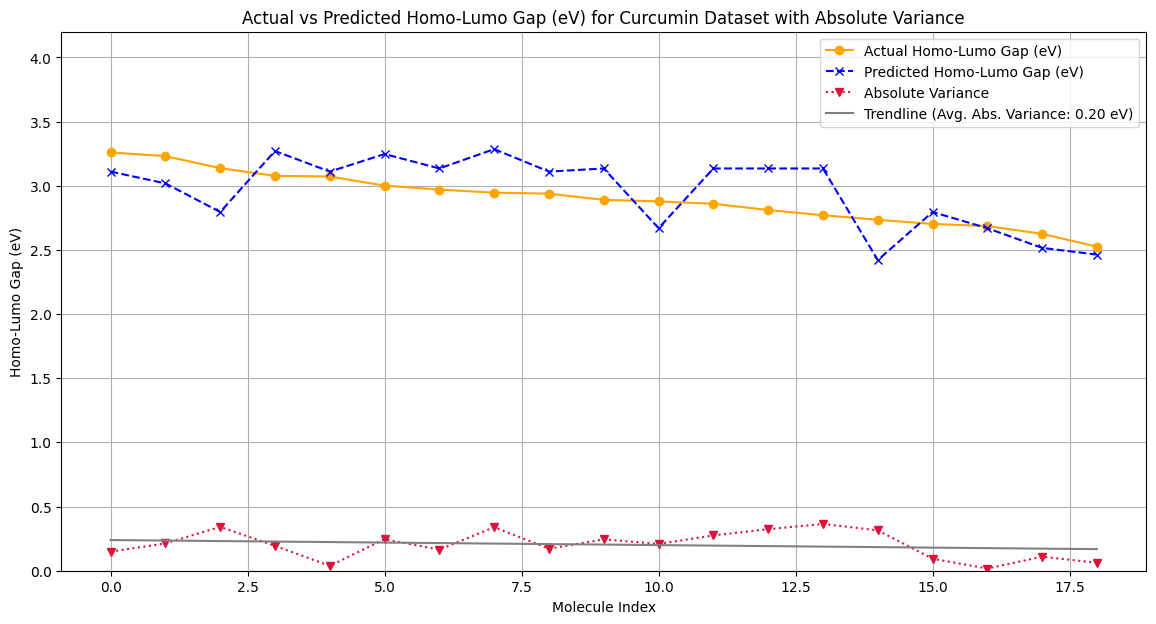

In [14]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Selected features from RFE
selected_features = [
    'morgan_92', 'morgan_97', 'morgan_162', 'morgan_213', 'morgan_216', 
    'morgan_281', 'morgan_350', 'morgan_352', 'morgan_360', 'morgan_361', 
    'morgan_389', 'morgan_489', 'morgan_552', 'morgan_656', 'morgan_674', 
    'morgan_675', 'morgan_694', 'morgan_699', 'morgan_787', 'morgan_803', 
    'morgan_807', 'morgan_875', 'morgan_896', 'morgan_926', 'morgan_980', 
    'morgan_1047', 'morgan_1088', 'morgan_1097', 'morgan_1136', 
    'morgan_1160', 'morgan_1164', 'morgan_1326', 'morgan_1357', 
    'morgan_1385', 'morgan_1452', 'morgan_1535', 'morgan_1565', 
    'morgan_1567', 'morgan_1594', 'morgan_1603', 'morgan_1611', 
    'morgan_1640', 'morgan_1747', 'morgan_1750', 'morgan_1810', 
    'morgan_1855', 'morgan_1866', 'morgan_1891', 'morgan_1984', 
    'morgan_1991'
]

# Load your dataset (for example, processed_similarity_dfs["seg01_atom_pair_cosine"])
df = processed_similarity_dfs["seg01_atom_pair_cosine"]
X = df[selected_features]
y = df['GAP_calc']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LightGBM parameters
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}

# Initialize and train the model on the selected features
model = lgb.LGBMRegressor(**tuned_params)
model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred_test = model.predict(X_test)
test_score = model.score(X_test, y_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Test Score (R²): {test_score:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Predict on the curcumin dataset using the same selected features
curcumin_X = curcumin_df_mf[selected_features]  # Apply selected features to curcumin dataset
curcumin_df_mf['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_X)

curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Save predictions to a CSV file
curcumin_df_mf.to_csv('curcumin_predictions_selected_features.csv', index=False)

# Calculate evaluation metrics for curcumin dataset
mae_curcumin = mean_absolute_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'])
rmse_curcumin = mean_squared_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], squared=False)

print(f"Curcumin Prediction MAE: {mae_curcumin:.4f}")
print(f"Curcumin Prediction RMSE: {rmse_curcumin:.4f}")

# Calculate absolute variance and average variance
curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Homo-Lumo Gap (eV)'] - curcumin_df_mf['Homo-Lumo Gap (eV) Pred']).abs()
average_variance = curcumin_df_mf['absolute_variance'].mean()
print(f"Average Absolute Variance: {average_variance:.4f}")

# Optional: Plot actual vs predicted for curcumin dataset along with absolute variance
plt.figure(figsize=(14, 7))

# Plot actual and predicted values
plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV)'], label='Actual Homo-Lumo Gap (eV)', marker='o', color='orange')
plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], label='Predicted Homo-Lumo Gap (eV)', marker='x', linestyle='--', color='blue')

# Plot absolute variance
plt.plot(curcumin_df_mf['absolute_variance'], label='Absolute Variance', marker='v', linestyle=':', color='crimson')

# Add trendline for absolute variance
x_vals = np.arange(len(curcumin_df_mf))
trendline = np.polyval(np.polyfit(x_vals, curcumin_df_mf['absolute_variance'], 1), x_vals)
plt.plot(trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

# Customize the plot
plt.xlabel('Molecule Index')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.title('Actual vs Predicted Homo-Lumo Gap (eV) for Curcumin Dataset with Absolute Variance')
plt.ylim(0,4.2)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# List of best models and their corresponding DataFrame keys
best_models_all_segments = [
    "seg01_atom_pair_cosine",
    "seg02_atom_pair_cosine",
    "seg03_atom_pair_kulczynski",
    "seg04_atom_pair_kulczynski",
    "seg05_atom_pair_kulczynski",
    "seg06_atom_pair_cosine"
]

# Loop over each model
for model_name in best_models_all_segments:
    print("___________________________________________________________________")
    print(f"Processing {model_name}")
    
    # Load the respective DataFrame
    df = processed_similarity_dfs[model_name]
    X = df.iloc[:, 4:]  # Features from the 4th column onwards
    y = df['GAP_calc']  # Target variable

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # LightGBM parameters and model initialization
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)

    # RFE for feature selection
    n_features_to_select = 50
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    
    # Train the model using the selected features
    model.fit(X_train[selected_features], y_train)
    y_pred_test = model.predict(X_test[selected_features])
    
    # Calculate metrics for the test set
    mae_model = mean_absolute_error(y_test, y_pred_test)
    rmse_model = mean_squared_error(y_test, y_pred_test, squared=False)
    r2_model = model.score(X_test[selected_features], y_test)
    
    print(f"Model {model_name}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    
    # Predict on the curcumin dataset using the same selected features
    curcumin_X = curcumin_df_mf[selected_features]
    curcumin_df_mf['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_X)

    # Sort by actual Homo-Lumo Gap for visualization
    curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

    # Calculate evaluation metrics for curcumin predictions
    mae_predict = mean_absolute_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], squared=False)
    r2_predict = model.score(curcumin_X, curcumin_df_mf['Homo-Lumo Gap (eV)'])

    print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
    print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
    print("___________________________________________________________________")

    # Calculate absolute variance and average variance
    curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Homo-Lumo Gap (eV)'] - curcumin_df_mf['Homo-Lumo Gap (eV) Pred']).abs()
    average_variance = curcumin_df_mf['absolute_variance'].mean()
    
    # Optional: Plot actual vs predicted for curcumin dataset along with absolute variance
    plt.figure(figsize=(14, 7))

    # Plot actual and predicted values
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV)'], label='Actual Homo-Lumo Gap (eV)', marker='o', color='orange')
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], label='Predicted Homo-Lumo Gap (eV)', marker='x', linestyle='--', color='blue')

    # Plot absolute variance
    plt.plot(curcumin_df_mf['absolute_variance'], label='Absolute Variance', marker='v', linestyle=':', color='crimson')

    # Plot trendline for absolute variance
    x_vals = np.arange(len(curcumin_df_mf))
    trendline = np.polyval(np.polyfit(x_vals, curcumin_df_mf['absolute_variance'], 1), x_vals)
    plt.plot(trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

    # Customize the plot
    plt.xlabel('Molecule Index')
    plt.ylabel('Homo-Lumo Gap (eV)')
    plt.title(f'Actual vs Predicted Homo-Lumo Gap (eV) for Curcumin Dataset ({model_name})')
    plt.ylim(0, 4.2)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()